# **1.LOAD DATASET**
The following libraries are required and imported below.

In [43]:
!pip install catboost

In [44]:
# === General utilities ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots

# === Preprocessing ===
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE


# === Modeling - Traditional ML ===
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# === Model evaluation ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

# === Unsupervised Learning ===
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    adjusted_rand_score, silhouette_score,
    normalized_mutual_info_score
)

This notebook works with a pre-cleaned, standardized dataset in tabular format.

Note: Upload your file (ET_EmoAgg_College_Tab.csv) to the current Colab session and make sure the file_path matches its name.

Expected format: a CSV file with features and aggression labels for each subject.

In [45]:
file_path = "ET_EmoAgg_College_Tab_.csv"  # Replace with your actual file name if different
df = pd.read_csv(file_path)

print("File loaded successfully. Shape:", df.shape)
df.head()

File loaded successfully. Shape: (5849, 12)


,media_id,media_name,aoi_id,aoi_name,user_id,aggressive,user_gender,time_to_first_view_sec,time_viewed_sec,time_viewed_percent,fixations,revisits
0,1,stimulus_1,6,positive_1,17,2,M,328.000,549.000,21.970,3.0,0
1,1,stimulus_1,6,positive_1,22,2,M,328.000,1.775,70.981,7.0,1
2,1,stimulus_1,6,positive_1,28,2,F,362.000,900.000,36.016,5.0,1
3,1,stimulus_1,6,positive_1,39,2,F,1.061,705.000,28.190,2.0,1
4,1,stimulus_1,6,positive_1,45,2,F,790.000,1.013,40.502,5.0,1


# **2. Data preprocessing**

In this section, we prepare the cleaned eye-tracking dataset for modeling. The steps include:

- Identifying categorical and numerical features
- Encoding categorical variables (media_name, aoi_name, user_gender)
- Removing neutral class samples
- Scaling selected numerical features


In [46]:
# Display categorical and numerical columns
print("Categorical columns:")
print(df.select_dtypes(include=["object", "category"]).columns.tolist())

print("\nNumerical columns:")
print(df.select_dtypes(include=["int64", "float64"]).columns.tolist())


Categorical columns:
['media_name', 'aoi_name', 'user_gender']

Numerical columns:
['media_id', 'aoi_id', 'user_id', 'aggressive', 'time_to_first_view_sec', 'time_viewed_sec', 'time_viewed_percent', 'fixations', 'revisits']


In [47]:
# Create a copy of the original DataFrame to encode
df_encoded = df.copy()

# Initialize label encoders
le_media = LabelEncoder()
le_aoi = LabelEncoder()
le_gender = LabelEncoder()

# Apply label encoding to categorical features
df_encoded["media_name"] = le_media.fit_transform(df_encoded["media_name"])
df_encoded["aoi_name"] = le_aoi.fit_transform(df_encoded["aoi_name"])
df_encoded["user_gender"] = le_gender.fit_transform(df_encoded["user_gender"])

# Preview the encoded DataFrame
df_encoded.head()


,media_id,media_name,aoi_id,aoi_name,user_id,aggressive,user_gender,time_to_first_view_sec,time_viewed_sec,time_viewed_percent,fixations,revisits
0,1,0,6,60,17,2,1,328.000,549.000,21.970,3.0,0
1,1,0,6,60,22,2,1,328.000,1.775,70.981,7.0,1
2,1,0,6,60,28,2,0,362.000,900.000,36.016,5.0,1
3,1,0,6,60,39,2,0,1.061,705.000,28.190,2.0,1
4,1,0,6,60,45,2,0,790.000,1.013,40.502,5.0,1


In [48]:
# Remove neutral class (label 2)
df_filtered = df_encoded[df_encoded["aggressive"] != 2].reset_index(drop=True)

# Define features to scale
columns_to_scale = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

# Standardize selected numerical features
scaler = StandardScaler()
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# Optional: save preprocessed dataset
df_filtered.to_csv("ET_EmoAgg_College_Tab_NO_NEUTRAL_SCALED.csv", index=False)

print("Scaled dataset saved as: ET_EmoAgg_College_Tab_NO_NEUTRAL_SCALED.csv")

Scaled dataset saved as: ET_EmoAgg_College_Tab_NO_NEUTRAL_SCALED.csv


# **3. Exploratory Data Analysis (EDA)**

This section explores the distribution and relationships of the numerical features in the dataset, as well as differences by aggression class. It includes:

- Class distribution
- Descriptive statistics
- Correlation matrix
- Boxplots per aggression class


In [49]:
# Use the preprocessed and scaled DataFrame created earlier
df = df_filtered.copy()

# Show basic info
print(df.shape)
print(df.dtypes)
df.head()

(4859, 12)
media_id                    int64
media_name                  int64
aoi_id                      int64
aoi_name                    int64
user_id                     int64
aggressive                  int64
user_gender                 int64
time_to_first_view_sec    float64
time_viewed_sec           float64
time_viewed_percent       float64
fixations                 float64
revisits                  float64
dtype: object


,media_id,media_name,aoi_id,aoi_name,user_id,aggressive,user_gender,time_to_first_view_sec,time_viewed_sec,time_viewed_percent,fixations,revisits
0,1,0,6,60,14,1,0,0.129593,-0.882286,0.317742,1.328959,1.275121
1,1,0,6,60,15,1,1,0.268635,-0.880916,1.070273,-0.173580,1.275121
2,1,0,6,60,19,1,0,0.084404,-0.882079,0.431520,0.327266,1.275121
3,1,0,6,60,24,1,0,0.341632,1.188207,-0.219769,0.327266,1.275121
4,1,0,6,60,27,1,0,0.233874,-0.882062,0.439979,0.327266,1.275121


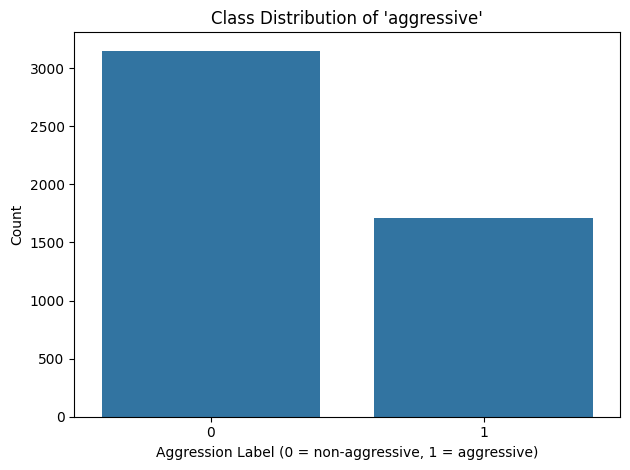

In [50]:
# Plot class distribution for 'aggressive'
sns.countplot(x="aggressive", data=df)
plt.title("Class Distribution of 'aggressive'")
plt.xlabel("Aggression Label (0 = non-aggressive, 1 = aggressive)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


We compute descriptive statistics (mean, std, quartiles) for each numerical feature grouped by aggression label.

In [51]:
# Descriptive statistics by aggression class for selected features
df.groupby("aggressive")[[
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]].describe().T


aggressive                              0            1
time_to_first_view_sec count  2817.000000  1553.000000
                       mean      0.014583    -0.026453
                       std       0.996219     1.006925
                       min      -1.149597    -1.149597
                       25%      -1.143754    -1.143865
                       50%       0.108736     0.105260
                       75%       0.477199     0.438962
                       max       2.319510     2.322986
time_viewed_sec        count  3150.000000  1708.000000
                       mean     -0.039863     0.073517
                       std       0.987112     1.019840
                       min      -0.885334    -0.885334
                       25%      -0.881908    -0.881892
                       50%      -0.879472    -0.304072
                       75%       0.901767     1.079220
                       max       1.906401     1.906401
time_viewed_percent    count  3150.000000  1708.000000
                       mean      0.025160    -0.046401
                       std       1.111589     0.750445
                       min      -1.360927    -1.360927
                       25%      -0.594035    -0.529648
                       50%      -0.038625    -0.060042
                       75%       0.565205     0.452322
                       max      20.594776     2.284450
fixations              count  3150.000000  1709.000000
                       mean     -0.011083     0.020428
                       std       1.024434     0.953588
                       min      -1.676119    -1.676119
                       25%      -0.674426    -0.674426
                       50%      -0.173580    -0.173580
                       75%       0.828113     0.828113
                       max       4.834883     4.334037
revisits               count  3150.000000  1709.000000
                       mean     -0.028518     0.052564
                       std       0.978419     1.037123
                       min      -0.577140    -0.577140
                       25%      -0.577140    -0.577140
                       50%      -0.577140    -0.577140
                       75%       1.275121     1.275121
                       max       8.684168     6.831906

The following heatmap shows Pearson correlations between the selected eye-tracking features.

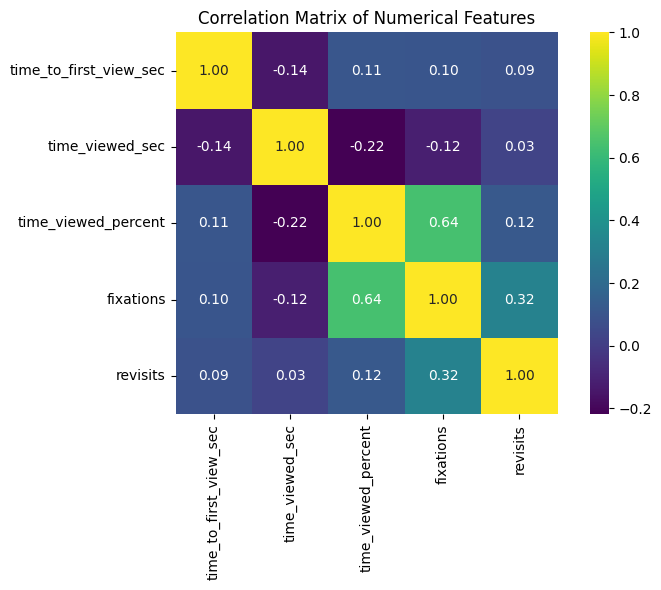

In [52]:
# Define numeric features to include in correlation analysis
numeric_cols = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

We visualize how each eye-tracking feature varies between aggressive and non-aggressive groups using boxplots.

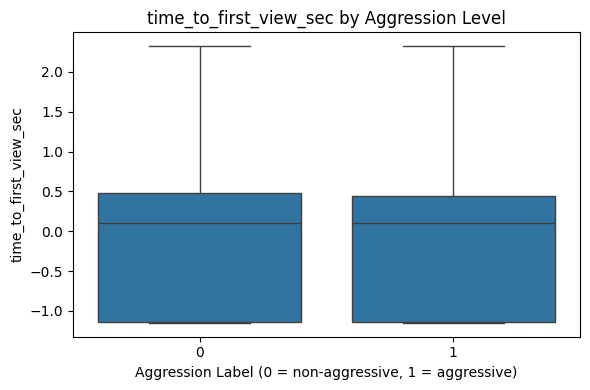

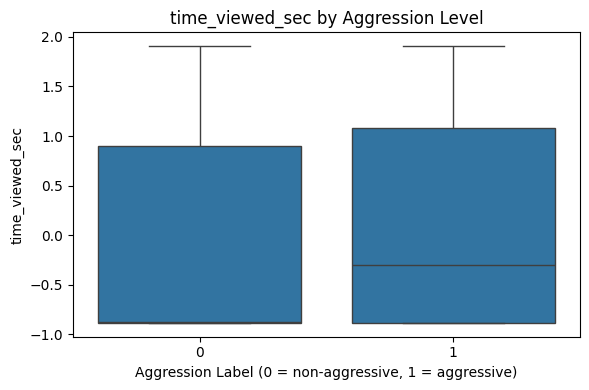

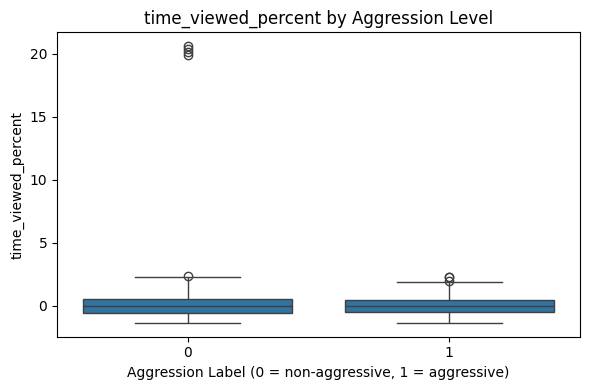

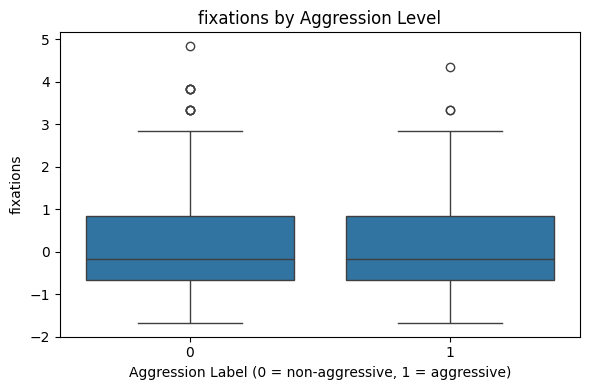

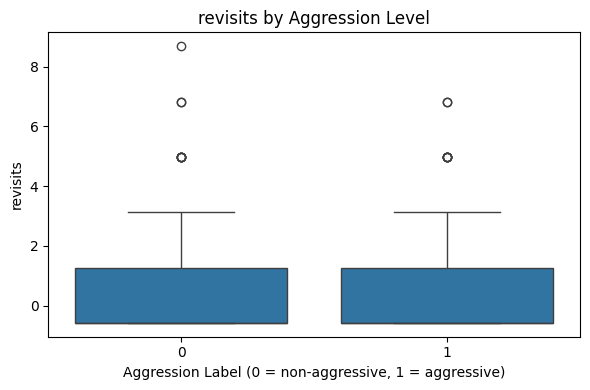

In [53]:
# Define features to visualize
features = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

# Generate boxplots by aggression class
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="aggressive", y=feature, data=df)
    plt.title(f"{feature} by Aggression Level")
    plt.xlabel("Aggression Label (0 = non-aggressive, 1 = aggressive)")
    plt.tight_layout()
    plt.show()


We print detailed statistics (count, mean, std, quartiles) for each numerical feature, grouped by aggression label.

In [54]:
# Print selected descriptive statistics for each feature grouped by aggression label
features = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

for feature in features:
    print(f"\n--- {feature.upper()} ---")
    stats = df.groupby("aggressive")[feature].describe()[["count", "mean", "std", "25%", "50%", "75%"]]
    print(stats)



--- TIME_TO_FIRST_VIEW_SEC ---
             count      mean       std       25%       50%       75%
aggressive                                                          
0           2817.0  0.014583  0.996219 -1.143754  0.108736  0.477199
1           1553.0 -0.026453  1.006925 -1.143865  0.105260  0.438962

--- TIME_VIEWED_SEC ---
             count      mean       std       25%       50%       75%
aggressive                                                          
0           3150.0 -0.039863  0.987112 -0.881908 -0.879472  0.901767
1           1708.0  0.073517  1.019840 -0.881892 -0.304072  1.079220

--- TIME_VIEWED_PERCENT ---
             count      mean       std       25%       50%       75%
aggressive                                                          
0           3150.0  0.025160  1.111589 -0.594035 -0.038625  0.565205
1           1708.0 -0.046401  0.750445 -0.529648 -0.060042  0.452322

--- FIXATIONS ---
             count      mean       std       25%      50%       75%

We visualize all numerical features side by side to identify outliers and differences in scale or distribution.

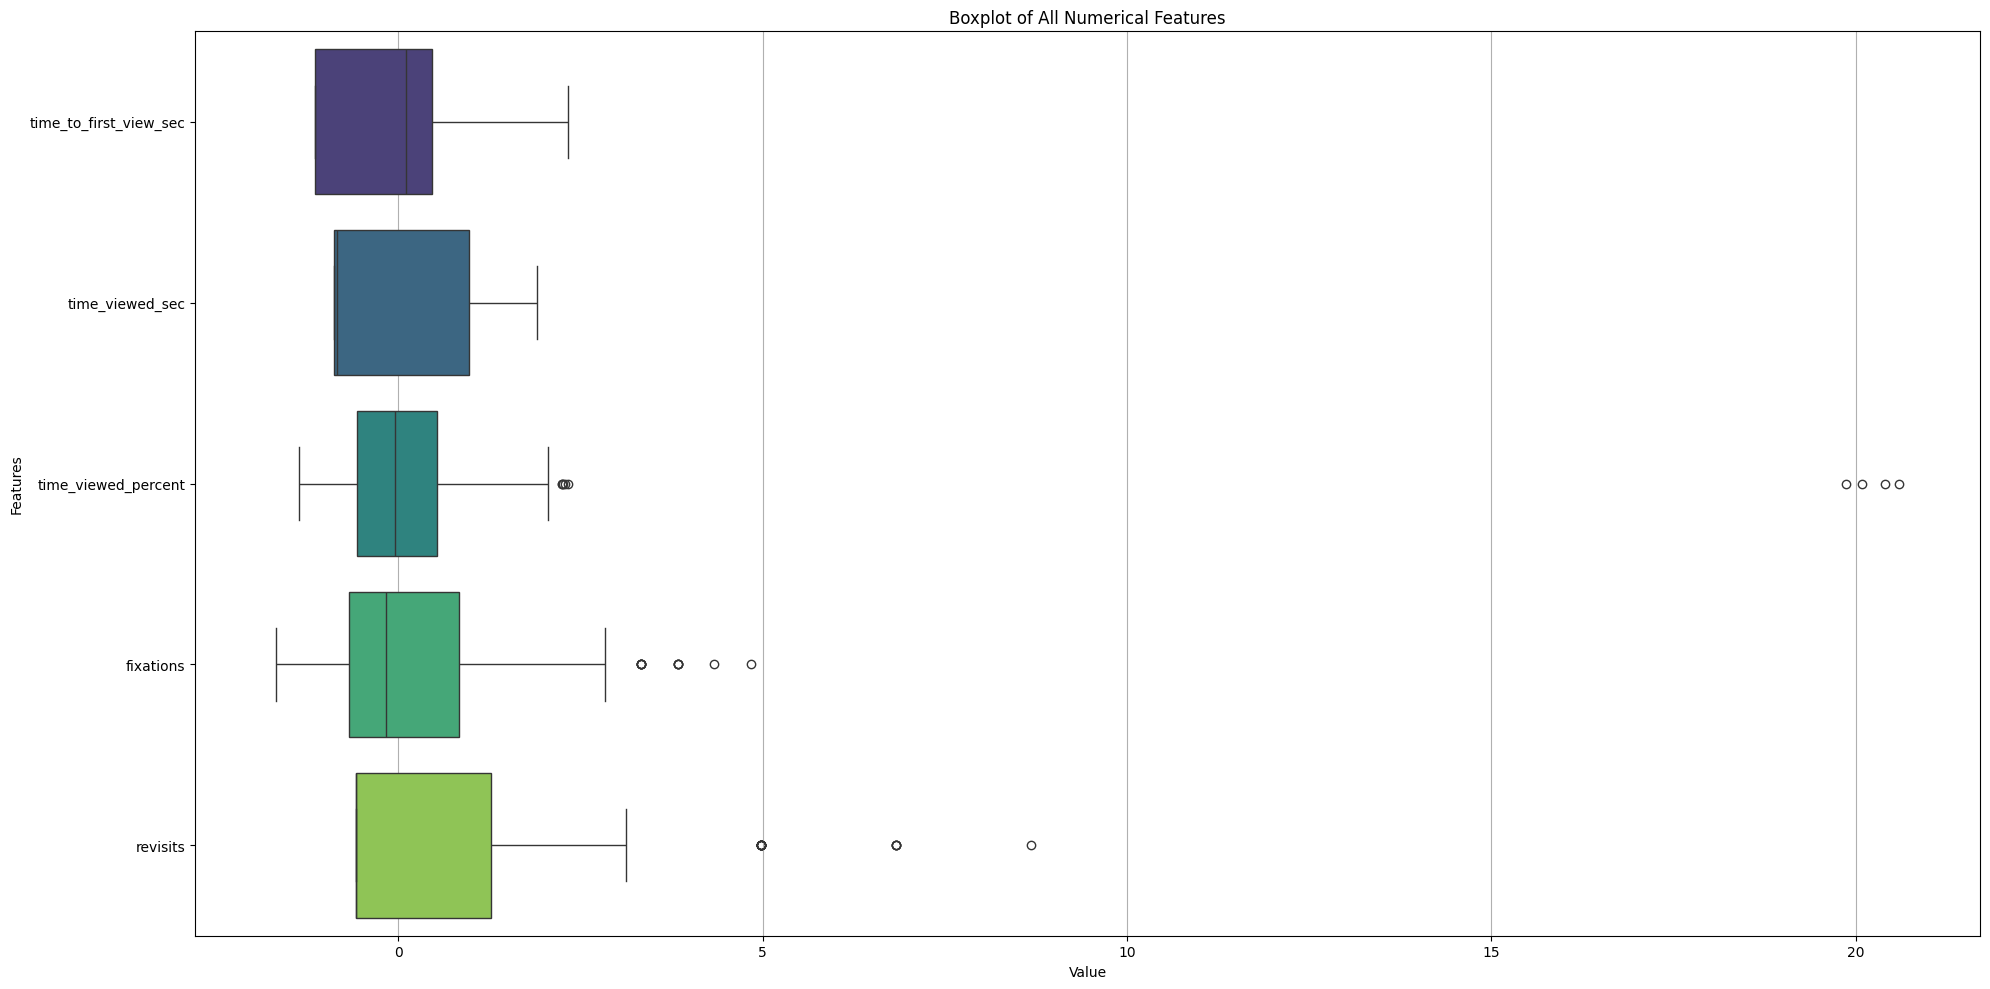

In [55]:
# Boxplot of all numerical features
features = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

plt.figure(figsize=(20, 10))
sns.boxplot(data=df[features], orient="h", palette="viridis")
plt.title("Boxplot of All Numerical Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#4. **Supervised Modeling – Feature Sets**
We prepare five different feature sets for supervised learning experiments on the college dataset:

1. **All features** (raw, no resampling
2. **All features + SMOTE** (for class balancing)
3. **PCA-reduced features** (retaining 95% of variance)
4. **Top 5 most important features** (via Random Forest importance)
5. **Top 5 features + SMOTE**

In [56]:
# === ENCODE CATEGORICAL VARIABLES ===
df_encoded = df.copy()
for col in ["media_name", "aoi_name", "user_gender"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# === IMPUTE MISSING VALUES (MEAN) ===
imputer = SimpleImputer(strategy="mean")
X_full = df_encoded.drop("aggressive", axis=1)
y_full = df_encoded["aggressive"]
X_imputed = imputer.fit_transform(X_full)

# ======================================================
# MODEL 1: All features (no resampling)
# ======================================================
X1 = X_imputed
y1 = y_full

# ======================================================
# MODEL 2: All features + SMOTE
# ======================================================
smote = SMOTE(random_state=42)
X2, y2 = smote.fit_resample(X1, y1)

# ======================================================
# MODEL 3: PCA-reduced features (95% variance)
# ======================================================
pca = PCA(n_components=0.95, random_state=42)
X3 = pca.fit_transform(X1)
y3 = y1

# ======================================================
# MODEL 4: Top 5 important features (Random Forest)
# ======================================================
rf = RandomForestClassifier(random_state=42)
rf.fit(X1, y1)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_full.columns[indices[:5]]
X4 = pd.DataFrame(X1, columns=X_full.columns)[top_features]
y4 = y1

# ======================================================
# MODEL 5: Top 5 features + SMOTE
# ======================================================
X5_base = pd.DataFrame(X1, columns=X_full.columns)[top_features]
y5_base = y1
X5, y5 = smote.fit_resample(X5_base, y5_base)



# **5. Supervised Models**

In this section, we evaluate the performance of several supervised machine learning models for aggression classification.  
We report classification metrics including precision, recall, F1-score, and the confusion matrix for each experiment.


In [57]:
# Dictionary of dataset variants used across all models
models = {
    "Model 1 - Original": (X1, y1),
    "Model 2 - SMOTE": (X2, y2),
    "Model 3 - PCA": (X3, y3),
    "Model 4 - Feature Selection": (X4, y4),
    "Model 5 - Feature Selection + SMOTE": (X5, y5)
}


Logistic regression

In [58]:
# Logistic Regression for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.653     0.954     0.775       630
           1      0.431     0.064     0.112       342

    accuracy                          0.641       972
   macro avg      0.542     0.509     0.443       972
weighted avg      0.575     0.641     0.542       972

Confusion Matrix:
[[601  29]
 [320  22]]

=== Model 2 - SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0      0.583     0.598     0.590       630
           1      0.587     0.571     0.579       630

    accuracy                          0.585      1260
   macro avg      0.585     0.585     0.585      1260
weighted avg      0.585     0.585     0.585      1260

Confusion Matrix:
[[377 253]
 [270 360]]

=== Model 3 - PCA ===
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0      0.648     1.000     0.787       630
           1      0.000     0.000     0.000       342

    accuracy                          0.648       972
   macro avg      0.324     0.500     0.393       972
weighted avg      0.420     0.648     0.510       972

Confusion Matrix:
[[630   0]
 [342   0]]

=== Model 4 - Feature Selection ===
Classification Report:
              precision    recall  f1-score   support

           0      0.651     0.997     0.787       630
           1      0.714     0.015     0.029       342

    accuracy                          0.651       972
   macro avg      0.683     0.506     0.408       972
weighted avg      0.673     0.651     0.520       972

Confusion Matrix:
[[628   2]
 [337   5]]

=== Model 5 - Feature Selection + SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0      0.555     0.552     0.554       630
           1      0.555    

Naive Bayes

In [64]:
# Gaussian Naive Bayes for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.675     0.795     0.730       630
           1      0.439     0.295     0.353       342

    accuracy                          0.619       972
   macro avg      0.557     0.545     0.542       972
weighted avg      0.592     0.619     0.598       972

Confusion Matrix:
[[501 129]
 [241 101]]

=== Model 2 - SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0      0.580     0.473     0.521       630
           1      0.555     0.657     0.602       630

    accuracy                          0.565      1260
   macro avg      0.567     0.565     0.561      1260
weighted avg      0.567     0.565     0.561      1260

Confusion Matrix:
[[298 332]
 [216 414]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.667     0.930     0.777       630
          

Decision tree

In [65]:
# Decision Tree Classifier for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       630
           1      1.000     1.000     1.000       342

    accuracy                          1.000       972
   macro avg      1.000     1.000     1.000       972
weighted avg      1.000     1.000     1.000       972

Confusion Matrix:
[[630   0]
 [  0 342]]

=== Model 2 - SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.984     0.988       630
           1      0.984     0.992     0.988       630

    accuracy                          0.988      1260
   macro avg      0.988     0.988     0.988      1260
weighted avg      0.988     0.988     0.988      1260

Confusion Matrix:
[[620  10]
 [  5 625]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       630
          

Random forest

In [66]:
# Random Forest Classifier for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.871     0.973     0.919       630
           1      0.937     0.734     0.823       342

    accuracy                          0.889       972
   macro avg      0.904     0.853     0.871       972
weighted avg      0.894     0.889     0.885       972

Confusion Matrix:
[[613  17]
 [ 91 251]]

=== Model 2 - SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0      0.924     0.949     0.937       630
           1      0.948     0.922     0.935       630

    accuracy                          0.936      1260
   macro avg      0.936     0.936     0.936      1260
weighted avg      0.936     0.936     0.936      1260

Confusion Matrix:
[[598  32]
 [ 49 581]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.998     0.996       630
          

Support vector machine

In [67]:
# Support Vector Machine (SVM) for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = SVC(kernel="rbf", probability=True, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.648     1.000     0.787       630
           1      0.000     0.000     0.000       342

    accuracy                          0.648       972
   macro avg      0.324     0.500     0.393       972
weighted avg      0.420     0.648     0.510       972

Confusion Matrix:
[[630   0]
 [342   0]]

=== Model 2 - SMOTE ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0      0.529     0.800     0.637       630
           1      0.590     0.287     0.386       630

    accuracy                          0.544      1260
   macro avg      0.559     0.544     0.512      1260
weighted avg      0.559     0.544     0.512      1260

Confusion Matrix:
[[504 126]
 [449 181]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.648     1.000     0.787       630
           1      0.000     0.000     0.000       342

    accuracy                          0.648       972
   macro avg      0.324     0.500     0.393       972
weighted avg      0.420     0.648     0.510       972

Confusion Matrix:
[[630   0]
 [342   0]]

=== Model 4 - Feature Selection ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0      0.648     1.000     0.787       630
           1      0.000     0.000     0.000       342

    accuracy                          0.648       972
   macro avg      0.324     0.500     0.393       972
weighted avg      0.420     0.648     0.510       972

Confusion Matrix:
[[630   0]
 [342   0]]

=== Model 5 - Feature Selection + SMOTE ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0      0.551     0.648     0.595       630
           1      0.572     0.471     0.517       630

    accuracy                          0.560      1260
   macro avg      0.561     0.560     0.556      1260
weighted avg      0.561     0.560     0.556      1260

Confusion Matrix:
[[408 222]
 [333 297]]


Multilayer perceptron

In [68]:
# Multilayer Perceptron (MLP) for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.656     0.967     0.782       630
           1      0.523     0.067     0.119       342

    accuracy                          0.650       972
   macro avg      0.589     0.517     0.450       972
weighted avg      0.609     0.650     0.549       972

Confusion Matrix:
[[609  21]
 [319  23]]

=== Model 2 - SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0      0.561     0.522     0.541       630
           1      0.553     0.592     0.572       630

    accuracy                          0.557      1260
   macro avg      0.557     0.557     0.557      1260
weighted avg      0.557     0.557     0.557      1260

Confusion Matrix:
[[329 301]
 [257 373]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.660     0.892     0.758       630
          

# **6 Additional Supervised Models**
In this section, we implement and evaluate three ensemble-based machine learning classifiers:
- **CatBoost Classifier**
- **Stacking Classifier**
- **Voting Classifier** (Hard and Soft)


Performance metrics include:
- Accuracy
- Precision (macro & weighted)
- Recall (macro & weighted)
- F1-score (macro & weighted)
- ROC AUC
- Confusion Matrix

All models use a consistent 80/20 train-test split and `random_state=42` for reproducibility.

**CATBOOST**

In [69]:
results = []

for name, (X, y) in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=3,
        verbose=0,
        random_state=42
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred).tolist()
    })

df_catboost_results = pd.DataFrame(results)
print(df_catboost_results)



                                 Model  Accuracy  Precision_macro  \
0                   Model 1 - Original  1.000000         1.000000   
1                      Model 2 - SMOTE  0.996032         0.996063   
2                        Model 3 - PCA  0.996914         0.997630   
3          Model 4 - Feature Selection  1.000000         1.000000   
4  Model 5 - Feature Selection + SMOTE  0.999206         0.999208   

   Precision_weighted  Recall_macro  Recall_weighted  F1_macro  F1_weighted  \
0            1.000000      1.000000         1.000000  1.000000     1.000000   
1            0.996063      0.996032         0.996032  0.996032     0.996032   
2            0.996928      0.995614         0.996914  0.996610     0.996910   
3            1.000000      1.000000         1.000000  1.000000     1.000000   
4            0.999208      0.999206         0.999206  0.999206     0.999206   

        AUC      Confusion_Matrix  
0  1.000000  [[630, 0], [0, 342]]  
1  0.999945  [[630, 0], [5, 625]]  
2 

**STACKING CLASSIFIER**

In [70]:
results = []

for name, (X, y) in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    base_models = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ]

    meta_model = CatBoostClassifier(
        iterations=500, learning_rate=0.1, depth=6,
        l2_leaf_reg=3, verbose=0, random_state=42
    )

    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5
    )
    stacking_clf.fit(X_train, y_train)

    y_pred = stacking_clf.predict(X_test)
    y_prob = stacking_clf.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred).tolist()
    })

df_stacking_results = pd.DataFrame(results)
print(df_stacking_results)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

                                 Model  Accuracy  Precision_macro  \
0                   Model 1 - Original  0.894033         0.889065   
1                      Model 2 - SMOTE  0.936508         0.936578   
2                        Model 3 - PCA  0.995885         0.994220   
3          Model 4 - Feature Selection  0.933128         0.925150   
4  Model 5 - Feature Selection + SMOTE  0.949206         0.949211   

   Precision_weighted  Recall_macro  Recall_weighted  F1_macro  F1_weighted  \
0            0.893349      0.876149         0.894033  0.881947     0.893139   
1            0.936578      0.936508         0.936508  0.936505     0.936505   
2            0.995932      0.996825         0.995885  0.995501     0.995890   
3            0.933535      0.929031         0.933128  0.927029     0.933279   
4            0.949211      0.949206         0.949206  0.949206     0.949206   

        AUC        Confusion_Matrix  
0  0.952639  [[590, 40], [63, 279]]  
1  0.980632  [[586, 44], [36, 594]

**VOTING CLASSIFIER**

In [71]:
results_hard = []
results_soft = []

for name, (X, y) in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    svm_model = SVC(probability=True, random_state=42)
    xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    gb_model = GradientBoostingClassifier(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)

    hard_voting_clf = VotingClassifier(estimators=[
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('gb', gb_model),
        ('rf', rf_model)
    ], voting='hard')

    soft_voting_clf = VotingClassifier(estimators=[
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('gb', gb_model),
        ('rf', rf_model)
    ], voting='soft')

    hard_voting_clf.fit(X_train, y_train)
    soft_voting_clf.fit(X_train, y_train)

    y_pred_hard = hard_voting_clf.predict(X_test)
    y_pred_soft = soft_voting_clf.predict(X_test)

    rf_model.fit(X_train, y_train)
    y_prob_hard = rf_model.predict_proba(X_test)[:, 1]
    y_prob_soft = soft_voting_clf.predict_proba(X_test)[:, 1]

    results_hard.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_hard),
        "Precision_macro": precision_score(y_test, y_pred_hard, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred_hard, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred_hard, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred_hard, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred_hard, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred_hard, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob_hard),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred_hard).tolist()
    })

    results_soft.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_soft),
        "Precision_macro": precision_score(y_test, y_pred_soft, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred_soft, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred_soft, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred_soft, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred_soft, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred_soft, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob_soft),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred_soft).tolist()
    })

df_results_hard = pd.DataFrame(results_hard)
df_results_soft = pd.DataFrame(results_soft)

print("Hard Voting Results:")
print(df_results_hard.sort_values(by="F1_weighted", ascending=False))

print("\nSoft Voting Results:")
print(df_results_soft.sort_values(by="F1_weighted", ascending=False))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:44:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Hard Voting Results:
                                 Model  Accuracy  Precision_macro  \
2                        Model 3 - PCA  0.990741         0.992958   
4  Model 5 - Feature Selection + SMOTE  0.975397         0.976551   
1                      Model 2 - SMOTE  0.969048         0.970852   
3          Model 4 - Feature Selection  0.945473         0.961201   
0                   Model 1 - Original  0.906379         0.936893   

   Precision_weighted  Recall_macro  Recall_weighted  F1_macro  F1_weighted  \
2            0.990871      0.986842         0.990741  0.989787     0.990712   
4            0.976551      0.975397         0.975397  0.975382     0.975382   
1            0.970852      0.969048         0.969048  0.969018     0.969018   
3            0.949704      0.922515         0.945473  0.937820     0.944284   
0            0.918195      0.866959         0.906379  0.889593     0.902348   

        AUC       Confusion_Matrix  
2  0.999921   [[630, 0], [9, 333]]  
4  0.989486  [[

# **7. Unsupervised Models**

In this section, we apply and evaluate multiple unsupervised clustering algorithms on eye-tracking data for aggression profiling:

- **K-Means (with PCA and t-SNE projections)**
- **DBSCAN (2D and 3D via t-SNE)**
- **Gaussian Mixture Models (GMM with 2 and 3 components)**

The data is preprocessed by:
- Encoding categorical variables
- Imputing missing values with the mean
- Optionally scaling the features for algorithms sensitive to scale

Performance is evaluated using the following clustering metrics:

- **Adjusted Rand Index (ARI)**
- **Silhouette Score**
- **Normalized Mutual Information (NMI)**

Visualizations are included for both 2D and 3D projections to interpret clustering quality.

In [72]:
# Load uploaded CSV
df = pd.read_csv("ET_EmoAgg_College_Tab_NO_NEUTRAL_SCALED.csv")

y_true = df["aggressive"]
X_unsupervised = df.drop(columns=["aggressive"])

print("X_unsupervised shape:", X_unsupervised.shape)
print("Unique labels in y_true:", y_true.unique())


X_unsupervised shape: (4859, 11)
Unique labels in y_true: [1 0]


We create a copy of the feature matrix and encode all categorical features using `LabelEncoder` to prepare for clustering.

In [74]:
X_clean = X_unsupervised.copy()
for col in X_clean.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_clean[col] = le.fit_transform(X_clean[col])


In [75]:
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_clean)


**K-Means**

KMeans + PCA results:
ARI: -0.0002
Silhouette Score: 0.5038
NMI: 0.0000


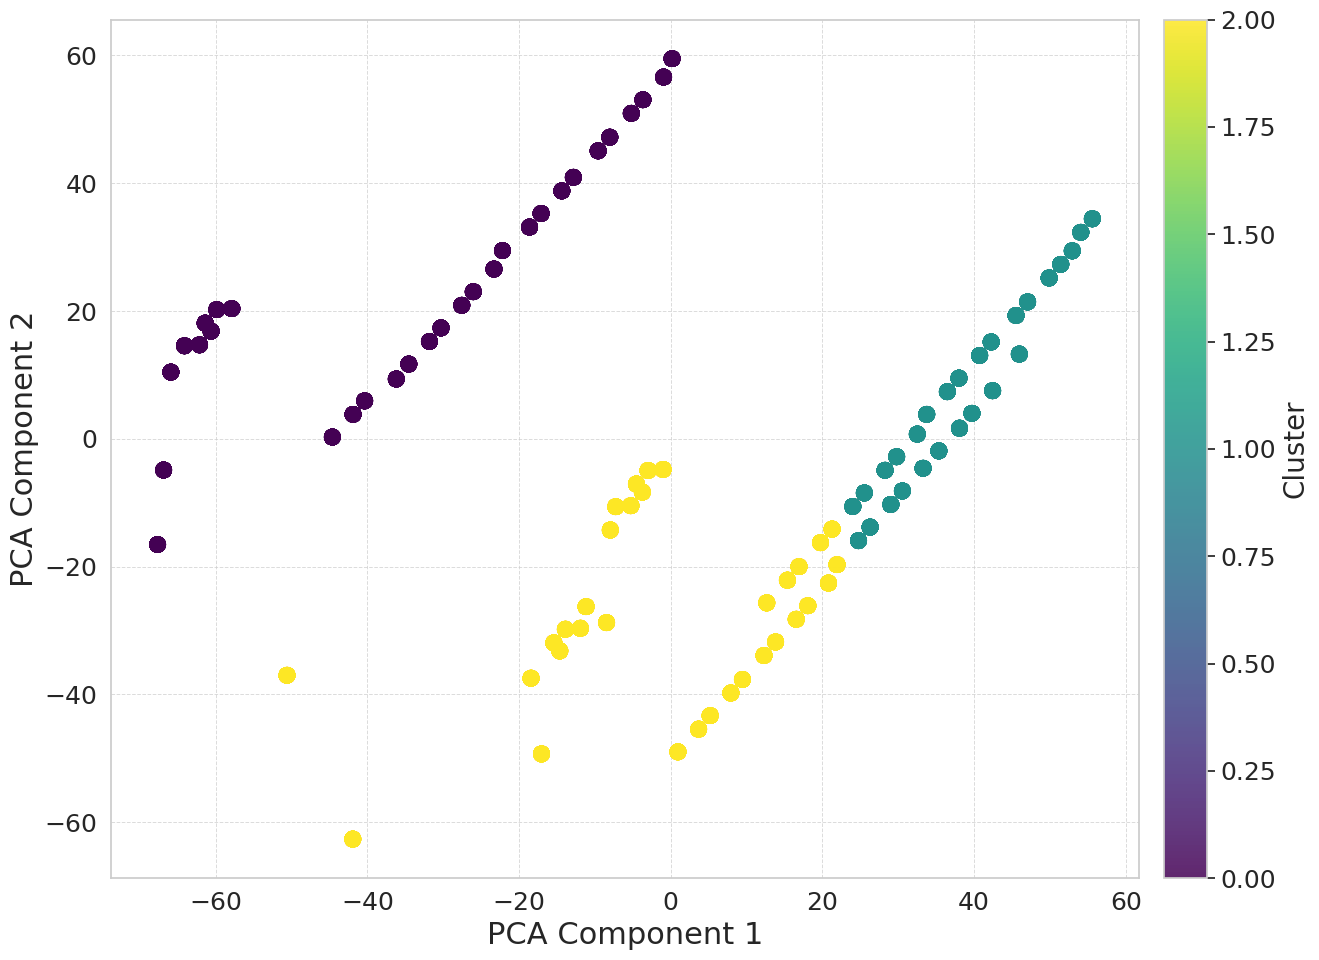

In [76]:
# Plot settings
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

# PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Metrics
ari = adjusted_rand_score(y_true, cluster_labels)
silhouette = silhouette_score(X_pca, cluster_labels)
nmi = normalized_mutual_info_score(y_true, cluster_labels)

print("KMeans + PCA results:")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"NMI: {nmi:.4f}")

# Visualization
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_labels, cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("PCA Component 1", fontsize=22)
plt.ylabel("PCA Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()


TSNE+K-MEANS

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KMeans + t-SNE results:
ARI: -0.0002
Silhouette Score: 0.4193
NMI: 0.0000


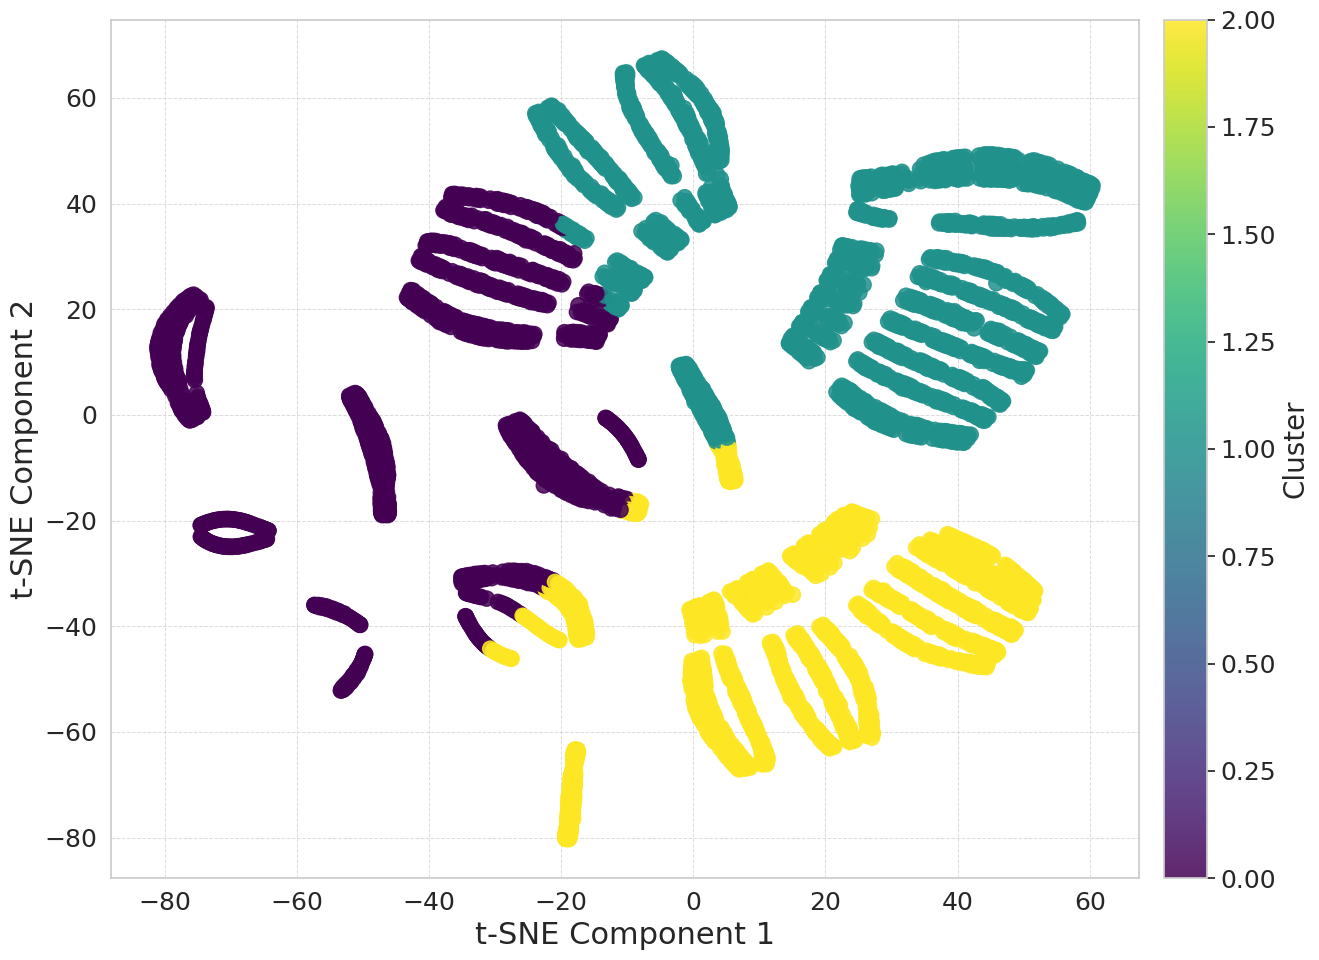

In [77]:
# Plot settings
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_tsne)

# Metrics
ari = adjusted_rand_score(y_true, cluster_labels)
silhouette = silhouette_score(X_tsne, cluster_labels)
nmi = normalized_mutual_info_score(y_true, cluster_labels)

print("KMeans + t-SNE results:")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"NMI: {nmi:.4f}")

# Visualization
palette = sns.color_palette("muted", n_colors=3)
cmap_continuo = LinearSegmentedColormap.from_list("muted_continuous", palette.as_hex())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("t-SNE Component 1", fontsize=22)
plt.ylabel("t-SNE Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


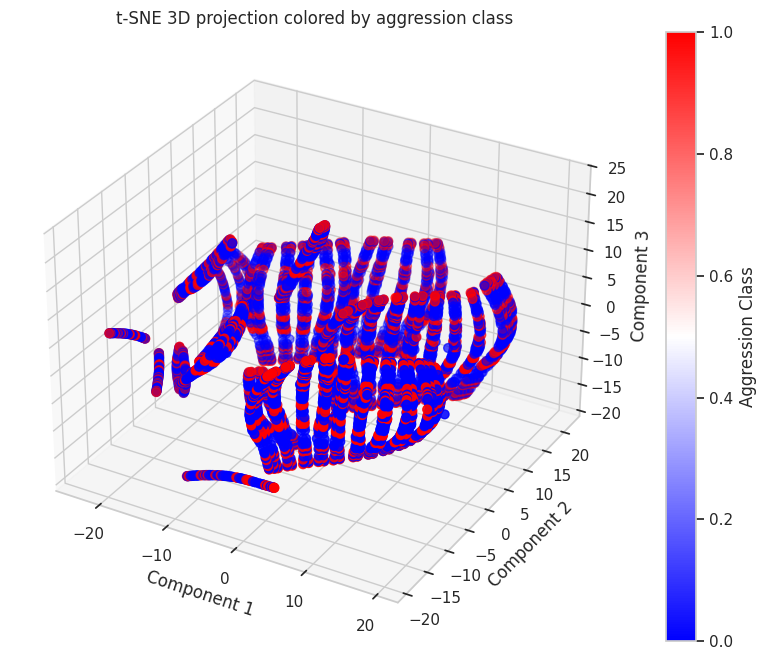

In [78]:
# 3D t-SNE projection
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_imputed)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
    c=y_true.astype(int), cmap='bwr', s=40
)

ax.set_title("t-SNE 3D projection colored by aggression class")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

plt.colorbar(sc, label="Aggression Class")
plt.tight_layout()
plt.show()


DBSCAN

DBSCAN on t-SNE 2D:
ARI: 0.0001
Silhouette: 0.4218
NMI: 0.0004
Unique clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)}


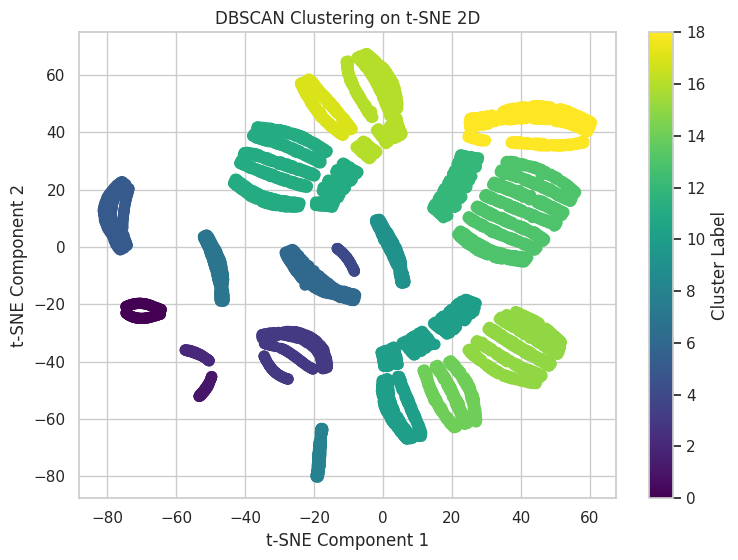

In [79]:
# DBSCAN clustering on 2D t-SNE
dbscan_2d = DBSCAN(eps=5, min_samples=5)
labels_2d = dbscan_2d.fit_predict(X_tsne)

# Evaluation metrics
ari_2d = adjusted_rand_score(y_true, labels_2d)
silhouette_2d = silhouette_score(X_tsne, labels_2d) if len(set(labels_2d)) > 1 else -1
nmi_2d = normalized_mutual_info_score(y_true, labels_2d)

print("DBSCAN on t-SNE 2D:")
print(f"ARI: {ari_2d:.4f}")
print(f"Silhouette: {silhouette_2d:.4f}")
print(f"NMI: {nmi_2d:.4f}")
print("Unique clusters:", set(labels_2d))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_2d, cmap='viridis', s=50)
plt.title("DBSCAN Clustering on t-SNE 2D")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster Label")
plt.tight_layout()
plt.show()


DBSCAN on t-SNE 3D:
ARI: -0.0003
Silhouette: 0.3257
NMI: 0.0000
Unique clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}


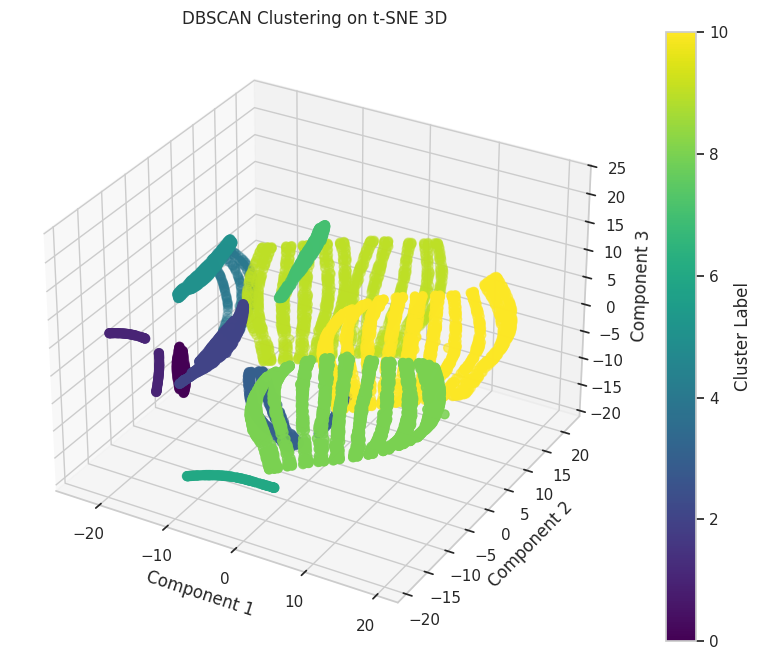

In [80]:
# DBSCAN clustering on 3D t-SNE
dbscan_3d = DBSCAN(eps=5, min_samples=5)
labels_3d = dbscan_3d.fit_predict(X_tsne_3d)

# Evaluation metrics
ari_3d = adjusted_rand_score(y_true, labels_3d)
silhouette_3d = silhouette_score(X_tsne_3d, labels_3d) if len(set(labels_3d)) > 1 else -1
nmi_3d = normalized_mutual_info_score(y_true, labels_3d)

print("DBSCAN on t-SNE 3D:")
print(f"ARI: {ari_3d:.4f}")
print(f"Silhouette: {silhouette_3d:.4f}")
print(f"NMI: {nmi_3d:.4f}")
print("Unique clusters:", set(labels_3d))

# 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=labels_3d, cmap='viridis', s=40)

ax.set_title("DBSCAN Clustering on t-SNE 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.colorbar(sc, label="Cluster Label")
plt.tight_layout()
plt.show()


In [83]:
# Preprocessing and clustering on original feature space
df = pd.read_csv("ET_EmoAgg_College_Tab_NO_NEUTRAL_SCALED.csv")

for col in ["media_name", "aoi_name", "user_gender"]:
    df[col] = LabelEncoder().fit_transform(df[col])

y_true = df["aggressive"].values
X = df.drop("aggressive", axis=1)

X_imputed = SimpleImputer(strategy="mean").fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# KMeans metrics
kmeans_results = {
    "ARI": adjusted_rand_score(y_true, kmeans_labels),
    "Silhouette": silhouette_score(X_scaled, kmeans_labels),
    "NMI": normalized_mutual_info_score(y_true, kmeans_labels)
}

# DBSCAN metrics
if len(set(dbscan_labels)) > 1:
    dbscan_results = {
        "ARI": adjusted_rand_score(y_true, dbscan_labels),
        "Silhouette": silhouette_score(X_scaled, dbscan_labels),
        "NMI": normalized_mutual_info_score(y_true, dbscan_labels)
    }
else:
    dbscan_results = {
        "ARI": adjusted_rand_score(y_true, dbscan_labels),
        "Silhouette": -1,
        "NMI": normalized_mutual_info_score(y_true, dbscan_labels)
    }

print("KMeans results:", kmeans_results)
print("DBSCAN results:", dbscan_results)




KMeans results: {'ARI': -0.0007066271223022945, 'Silhouette': np.float64(0.13732385217724666), 'NMI': np.float64(8.182875325561004e-06)}
DBSCAN results: {'ARI': 0.0110936777783312, 'Silhouette': np.float64(-0.045695186067364606), 'NMI': np.float64(0.00847312554260248)}


GMM Results: {'ARI': -0.0004483553057253445, 'Silhouette': np.float64(0.13713017727429702), 'NMI': np.float64(2.133680476115949e-06)}


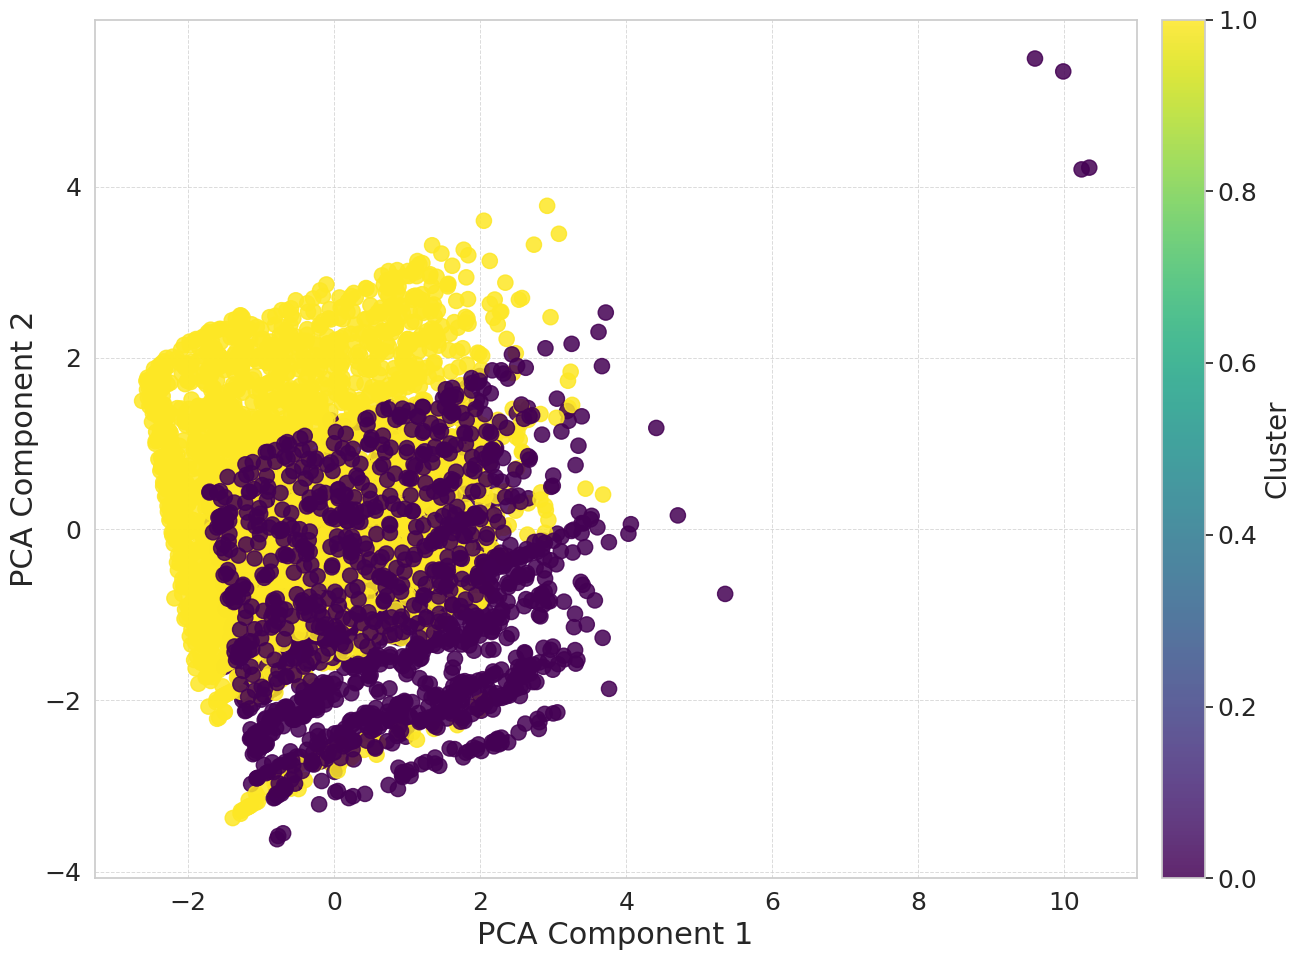

In [84]:
# GMM clustering and PCA visualization (2 components)
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

gmm_metrics = {
    "ARI": adjusted_rand_score(y_true, gmm_labels),
    "Silhouette": silhouette_score(X_scaled, gmm_labels),
    "NMI": normalized_mutual_info_score(y_true, gmm_labels)
}
print("GMM Results:", gmm_metrics)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

palette = sns.color_palette("muted", n_colors=2)
cmap_continuo = LinearSegmentedColormap.from_list("muted_continuous", palette.as_hex())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=gmm_labels,
    cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("PCA Component 1", fontsize=22)
plt.ylabel("PCA Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

GMM (3 components) Results: {'ARI': 0.0031266624818127647, 'Silhouette': np.float64(0.12582797502496762), 'NMI': np.float64(0.000737362452195431)}


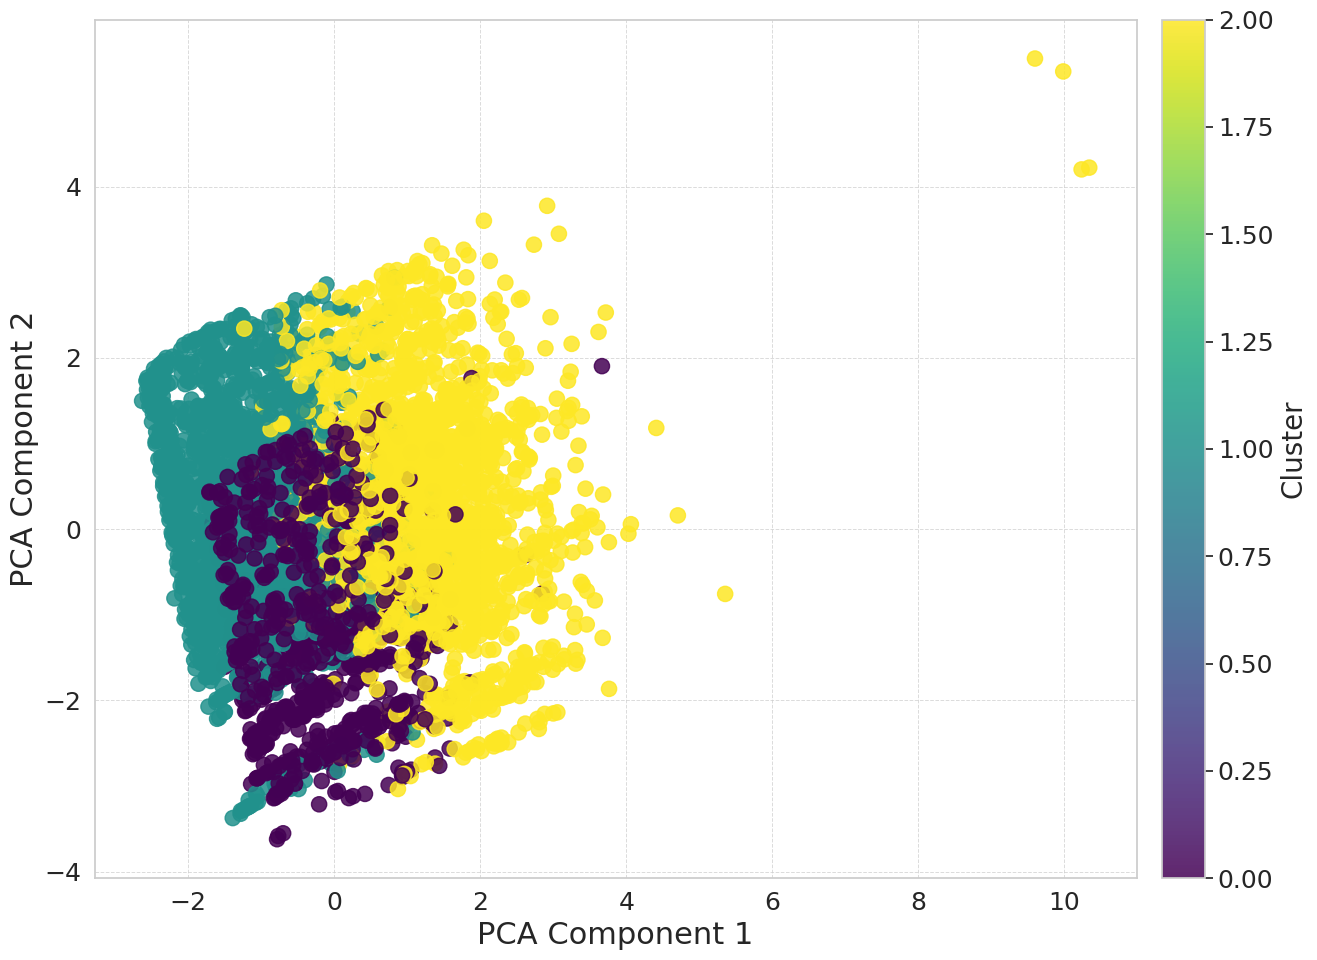

In [85]:
# GMM clustering with 3 components and PCA visualization
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

gmm3 = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels_3 = gmm3.fit_predict(X_scaled)

gmm3_metrics = {
    "ARI": adjusted_rand_score(y_true, gmm_labels_3),
    "Silhouette": silhouette_score(X_scaled, gmm_labels_3),
    "NMI": normalized_mutual_info_score(y_true, gmm_labels_3)
}
print("GMM (3 components) Results:", gmm3_metrics)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

palette = sns.color_palette("muted", n_colors=3)
cmap_continuo = LinearSegmentedColormap.from_list("muted_continuous", palette.as_hex())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=gmm_labels_3,
    cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("PCA Component 1", fontsize=22)
plt.ylabel("PCA Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# **9. RESULTADOS**

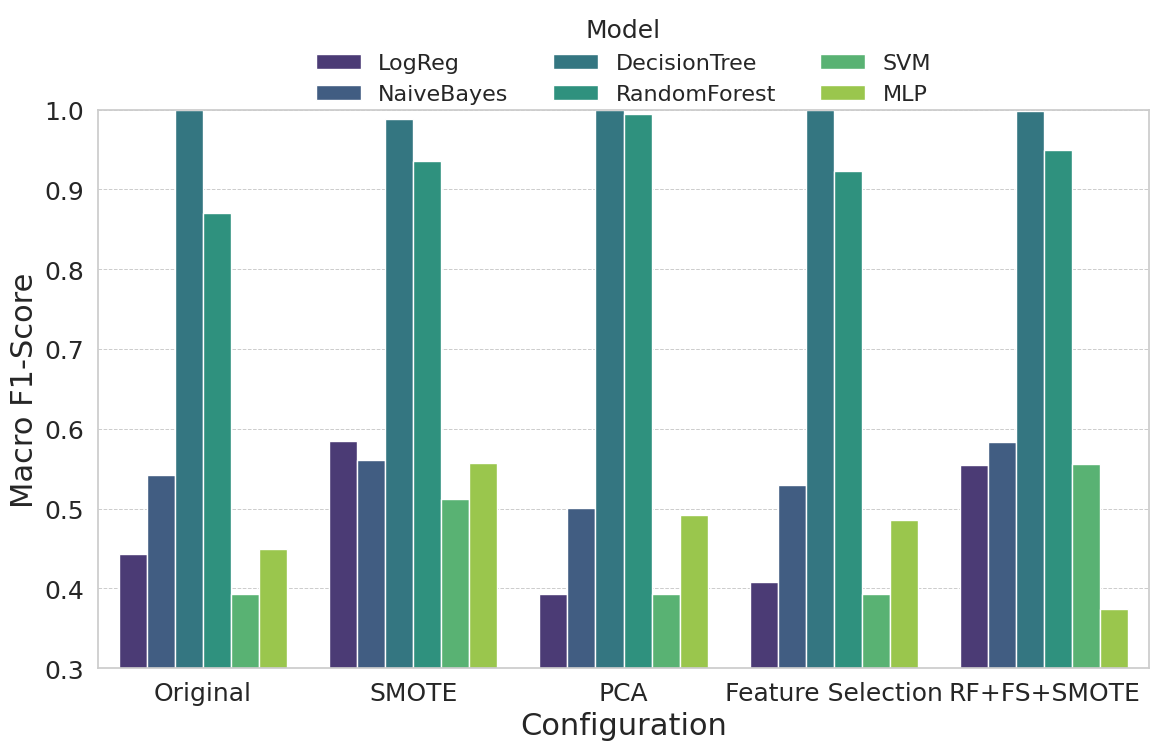

In [86]:
# Prepare data for visualization
configs = ['Original', 'SMOTE', 'PCA', 'Feature Selection', 'RF+FS+SMOTE']
f1_scores = {
    'LogReg': [0.443, 0.585, 0.393, 0.408, 0.555],
    'NaiveBayes': [0.542, 0.561, 0.501, 0.530, 0.583],
    'DecisionTree': [1.000, 0.988, 1.000, 1.000, 0.998],
    'RandomForest': [0.871, 0.936, 0.994, 0.923, 0.949],
    'SVM': [0.393, 0.512, 0.393, 0.393, 0.556],
    'MLP': [0.450, 0.557, 0.492, 0.486, 0.374],
}

# Convert to DataFrame (long format for seaborn)
df = pd.DataFrame(f1_scores, index=configs).reset_index().melt(id_vars='index')
df.columns = ['Configuration', 'Model', 'Macro F1-Score']

# Plot
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid', font_scale=1.6)

ax = sns.barplot(
    data=df,
    x='Configuration',
    y='Macro F1-Score',
    hue='Model',
    palette='viridis'
)

# Labels and ticks
ax.set_ylabel('Macro F1-Score', fontsize=22)
ax.set_xlabel('Configuration', fontsize=22)
ax.set_ylim(0.3, 1.0)
ax.tick_params(axis='x', rotation=0, labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# Horizontal legend
ax.legend(
    title='Model',
    fontsize=16,
    title_fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.20),
    ncol=3,
    frameon=False
)

# Grid and layout
ax.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


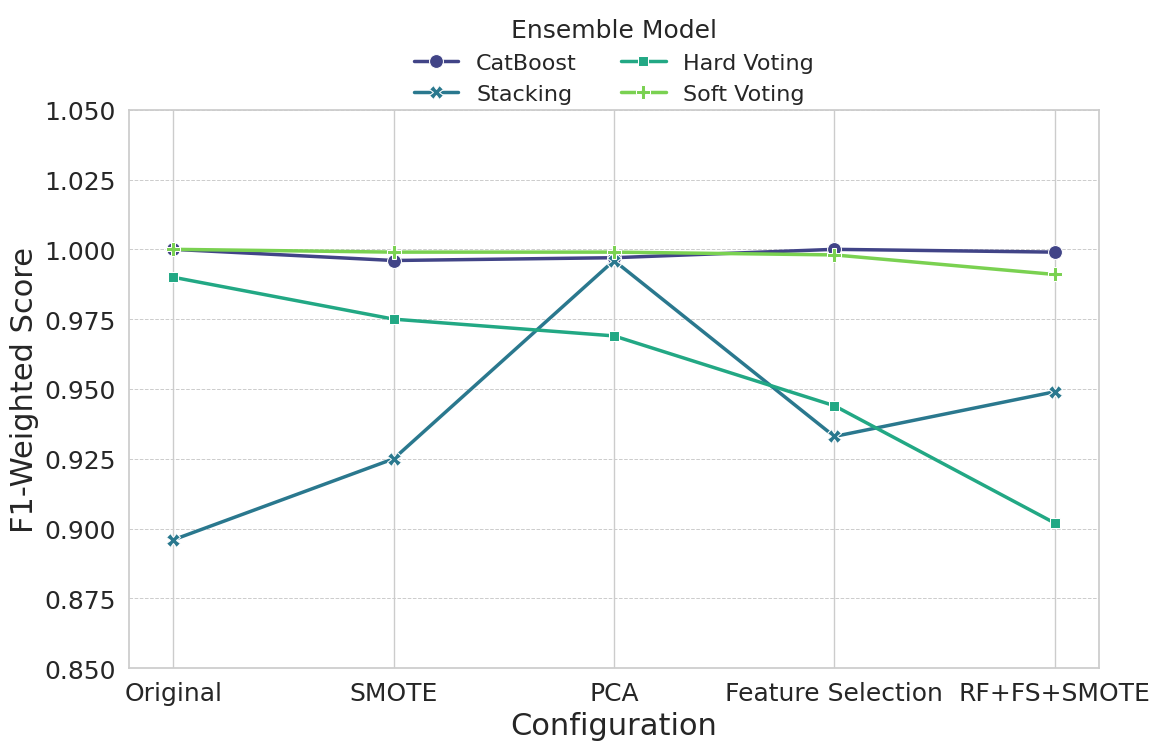

In [87]:
#Data
configs = ['Original', 'SMOTE', 'PCA', 'Feature Selection', 'RF+FS+SMOTE']
f1_weighted_college = {
    'CatBoost': [1.000, 0.996, 0.997, 1.000, 0.999],
    'Stacking': [0.896, 0.925, 0.996, 0.933, 0.949],
    'Hard Voting': [0.990, 0.975, 0.969, 0.944, 0.902],
    'Soft Voting': [1.000, 0.999, 0.999, 0.998, 0.991],
}


df = pd.DataFrame(f1_weighted_college, index=configs).reset_index().melt(id_vars='index')
df.columns = ['Configuration', 'Model', 'F1-Weighted Score']


sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(12, 8))

# Plot
ax = sns.lineplot(
    data=df,
    x='Configuration',
    y='F1-Weighted Score',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False,
    linewidth=2.5,
    markersize=10,
    palette='viridis'
)


ax.set_ylabel('F1-Weighted Score', fontsize=22)
ax.set_xlabel('Configuration', fontsize=22)
ax.set_ylim(0.85, 1.05)
ax.tick_params(axis='x', rotation=0, labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.legend(
    title='Ensemble Model',
    fontsize=16,
    title_fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.20),
    ncol=2,
    frameon=False
)


ax.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()



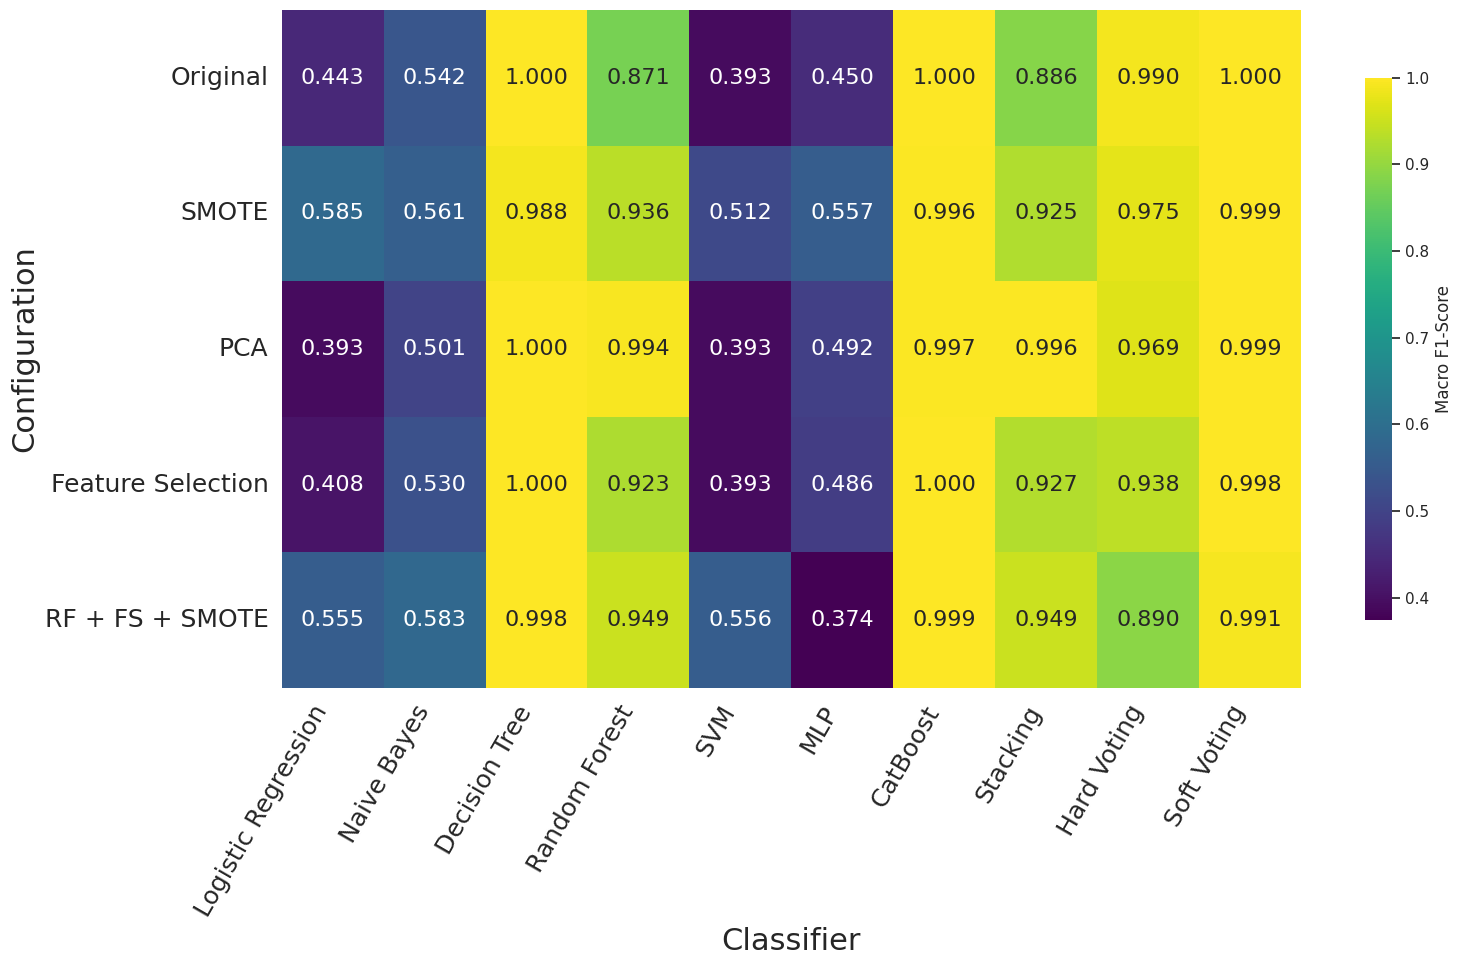

In [91]:
#F1_macro
data_college = {
    'Original': {
        'Logistic Regression': 0.443,
        'Naive Bayes': 0.542,
        'Decision Tree': 1.000,
        'Random Forest': 0.871,
        'SVM': 0.393,
        'MLP': 0.450,
        'CatBoost': 1.000,
        'Stacking': 0.886,
        'Hard Voting': 0.990,
        'Soft Voting': 1.000,
    },
    'SMOTE': {
        'Logistic Regression': 0.585,
        'Naive Bayes': 0.561,
        'Decision Tree': 0.988,
        'Random Forest': 0.936,
        'SVM': 0.512,
        'MLP': 0.557,
        'CatBoost': 0.996,
        'Stacking': 0.925,
        'Hard Voting': 0.975,
        'Soft Voting': 0.999,
    },
    'PCA': {
        'Logistic Regression': 0.393,
        'Naive Bayes': 0.501,
        'Decision Tree': 1.000,
        'Random Forest': 0.994,
        'SVM': 0.393,
        'MLP': 0.492,
        'CatBoost': 0.997,
        'Stacking': 0.996,
        'Hard Voting': 0.969,
        'Soft Voting': 0.999,
    },
    'Feature Selection': {
        'Logistic Regression': 0.408,
        'Naive Bayes': 0.530,
        'Decision Tree': 1.000,
        'Random Forest': 0.923,
        'SVM': 0.393,
        'MLP': 0.486,
        'CatBoost': 1.000,
        'Stacking': 0.927,
        'Hard Voting': 0.938,
        'Soft Voting': 0.998,
    },
    'RF + FS + SMOTE': {
        'Logistic Regression': 0.555,
        'Naive Bayes': 0.583,
        'Decision Tree': 0.998,
        'Random Forest': 0.949,
        'SVM': 0.556,
        'MLP': 0.374,
        'CatBoost': 0.999,
        'Stacking': 0.949,
        'Hard Voting': 0.890,
        'Soft Voting': 0.991,
    }
}

#Dataframe
df_college = pd.DataFrame(data_college).T

#Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    df_college,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Macro F1-Score', 'shrink': 0.8},
    annot_kws={"size": 16}
)


plt.xlabel('Classifier', fontsize=22)
plt.ylabel('Configuration', fontsize=22)
plt.xticks(rotation=60, fontsize=18, ha='right')
plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.show()



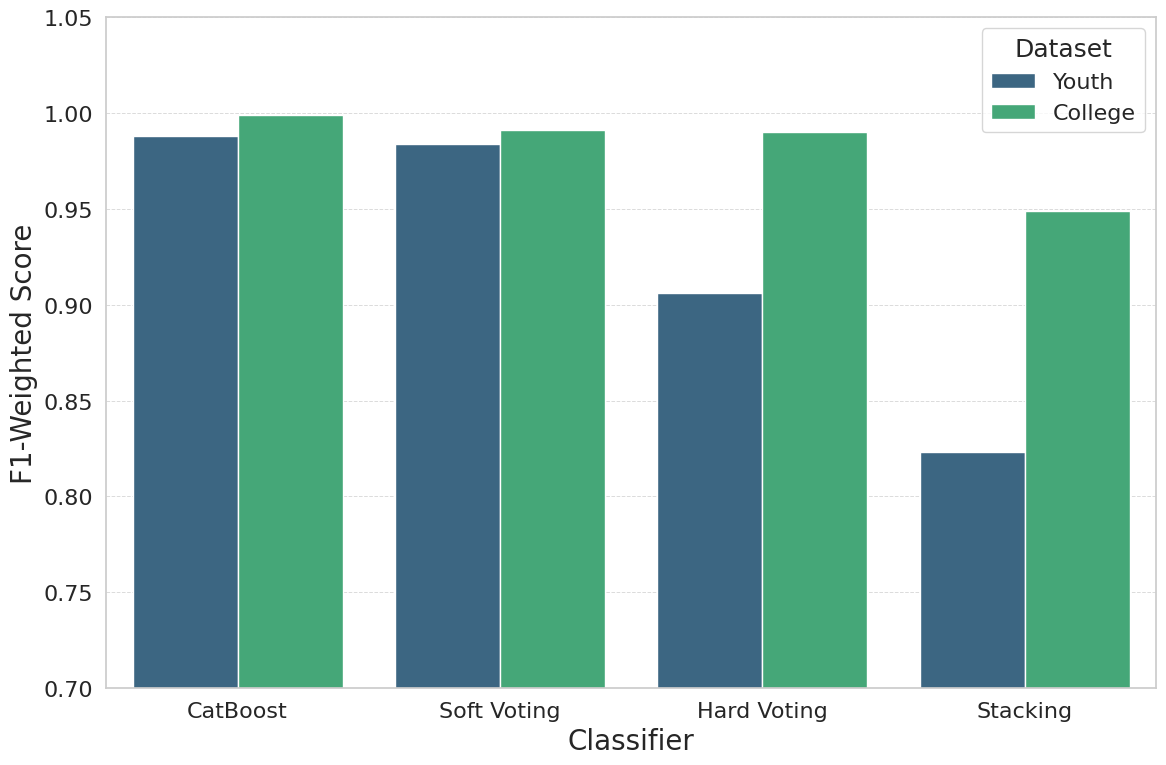

In [89]:
# Data F1-weighted best classifiers (Youth+College)
data_fig21 = pd.DataFrame({
    'Classifier': ['CatBoost', 'Soft Voting', 'Hard Voting', 'Stacking'],
    'Youth': [0.988, 0.984, 0.906, 0.823],
    'College': [0.999, 0.991, 0.990, 0.949]
})

df_melted = data_fig21.melt(id_vars='Classifier', var_name='Dataset', value_name='F1-weighted')

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_melted,
    x='Classifier',
    y='F1-weighted',
    hue='Dataset',
    palette='viridis'
)

ax.set_ylabel('F1-Weighted Score', fontsize=20)
ax.set_xlabel('Classifier', fontsize=20)
ax.set_ylim(0.7, 1.05)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(title='Dataset', fontsize=16, title_fontsize=18, loc='upper right')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


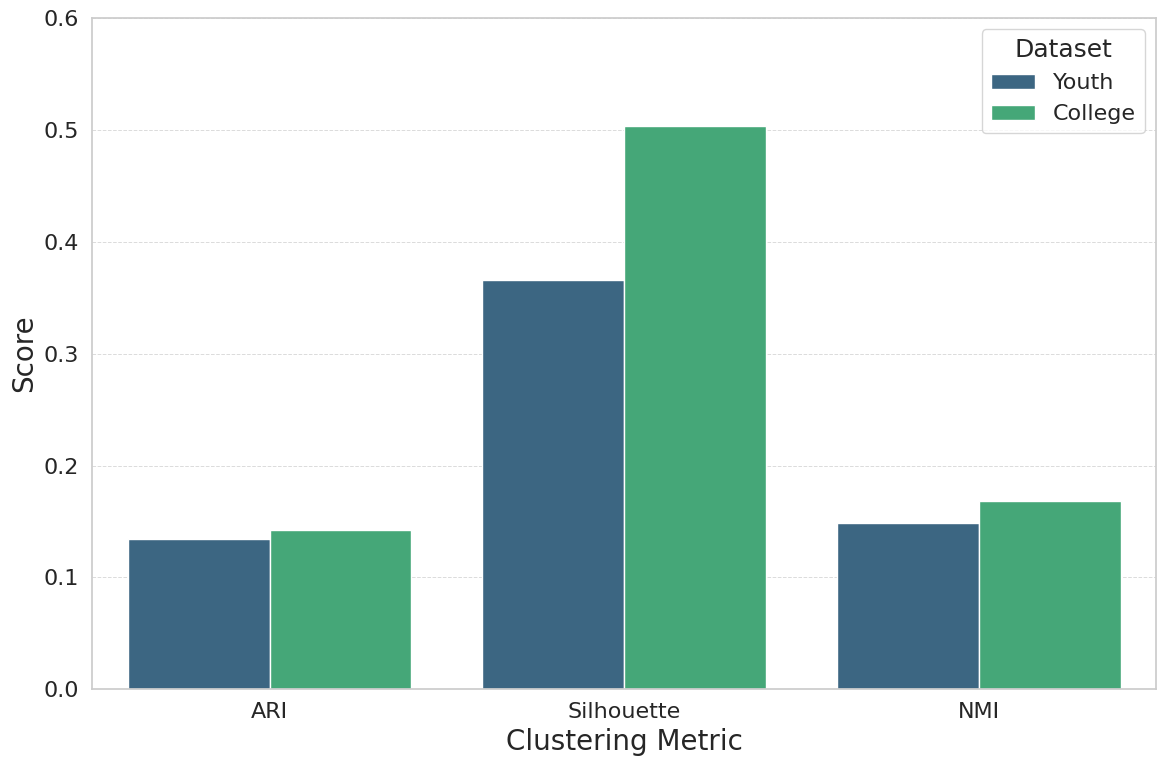

In [90]:
#Clustering metrics (Youth+College)
data_fig22 = pd.DataFrame({
    'Metric': ['ARI', 'Silhouette', 'NMI'],
    'Youth': [0.1342, 0.3661, 0.1487],     # Mejores resultados GMM + PCA para Youth
    'College': [0.1427, 0.5038, 0.1681]    # Mejores resultados GMM + PCA para College
})

df_melted2 = data_fig22.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_melted2,
    x='Metric',
    y='Score',
    hue='Dataset',
    palette='viridis'
)

ax.set_ylabel('Score', fontsize=20)
ax.set_xlabel('Clustering Metric', fontsize=20)
ax.set_ylim(0, 0.6)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(title='Dataset', fontsize=16, title_fontsize=18, loc='upper right')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()

